In [194]:
import os
import datetime
import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.utils import shuffle
from sklearn.impute import SimpleImputer

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras import layers, optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import plot_model
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

import sys
sys.path.append(r'C:\Users\10768\personal files\waiting_time\waiting_time_project')

from utils.logger import logger
from data_process import get_apptointment_info, get_treat_info, fill_nan, get_list
from wtp.duration.predict_duration_lgb import FEATURE_NUM, FEATURE_CATE
from wtp.duration.config_duration import DT_MODEL_DIR

import warnings
warnings.filterwarnings("ignore")

# 1 Process Data

In [2]:
processed_appointment_data_ = get_apptointment_info()
processed_treatment_data_ = get_treat_info()

processed_appointment_data = processed_appointment_data_.copy()
processed_treatment_data = processed_treatment_data_.copy()

processed_appointment_data = processed_appointment_data.drop_duplicates().reset_index(drop=True)
processed_treatment_data = processed_treatment_data.drop_duplicates().reset_index(drop=True)

WAITING TIME: 2020-08-17 09:52:44 [INFO] Get information about appointment!
WAITING TIME: 2020-08-17 09:52:44 [DEBUG] Get table of appointment!
WAITING TIME: 2020-08-17 09:53:29 [DEBUG] Get table of patient!
WAITING TIME: 2020-08-17 09:53:31 [DEBUG] Merge appointment and patient!
WAITING TIME: 2020-08-17 09:53:31 [DEBUG] Get table of patientdoctor!
WAITING TIME: 2020-08-17 09:53:34 [DEBUG] Merge patientdoctor!
WAITING TIME: 2020-08-17 09:53:34 [DEBUG] Get table of diagnosis!
WAITING TIME: 2020-08-17 09:53:35 [DEBUG] Get table of diagnosis!
WAITING TIME: 2020-08-17 09:53:35 [DEBUG] Merge diagnosis and diagnosistranslation!
WAITING TIME: 2020-08-17 09:53:35 [DEBUG] Get table of course!
WAITING TIME: 2020-08-17 09:53:37 [DEBUG] Get table of plan!
WAITING TIME: 2020-08-17 09:53:41 [DEBUG] Merge plan and course!
WAITING TIME: 2020-08-17 09:53:41 [DEBUG] Merge plan_course and appointment!
WAITING TIME: 2020-08-17 09:53:42 [DEBUG] Drop columns with same values!
WAITING TIME: 2020-08-17 09:53:

In [3]:
processed_data = pd.merge(processed_appointment_data, processed_treatment_data, on=['PatientSerNum', 'date'], how='inner')
# processed_data = processed_data.sort_values(
#     by=['PatientSerNum', 'AppointmentSerNum', 'ScheduledStartTime', 'FractionNumber']).reset_index(drop=True)

imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
imp_mean.fit(processed_data[FEATURE_NUM])
processed_data.loc[:, FEATURE_NUM] = imp_mean.transform(processed_data[FEATURE_NUM])

In [4]:
FEATURE_CATE.remove('FractionNumber')

In [5]:
cate_onehot_data = pd.DataFrame({})
update_cate_features = []
for feature in FEATURE_CATE:
    tmp = pd.get_dummies(processed_data[[feature]], prefix=f"{feature}_")
    update_cate_features.extend(tmp.columns)
    cate_onehot_data = pd.concat([cate_onehot_data, tmp], axis=1)

cate_onehot_data['AppointmentSerNum'] = processed_data['AppointmentSerNum']
cate_onehot_data = cate_onehot_data.groupby(by='AppointmentSerNum').sum()

In [6]:
num_features_single_value = ['age', 'Scheduled_duration', 'Actual_duration']

num_features_multiple_value = ['ImagesTaken', 'MU', 'MUCoeff', 'TreatmentTime']

num_data_single_value = processed_data[num_features_single_value + ['AppointmentSerNum']]
num_data_single_value = num_data_single_value.groupby(by='AppointmentSerNum').mean()
num_data_single_value = num_data_single_value.reset_index(drop=False)

num_data_multiple_value = processed_data[num_features_multiple_value + ['AppointmentSerNum']]
num_data_multiple_value = num_data_multiple_value.groupby(by='AppointmentSerNum').sum()
num_data_multiple_value = num_data_multiple_value.reset_index(drop=False)

In [7]:
information_features = [
    'PatientSerNum', 'AppointmentSerNum',
    'ScheduledStartTime', 'ScheduledEndTime', 'ActualStartDate', 'ActualEndDate'
]# FractionNumber
information_data = processed_data[information_features]
information_data = information_data.drop_duplicates().reset_index(drop=True)

In [8]:
num_data = pd.merge(num_data_single_value, num_data_multiple_value, on='AppointmentSerNum', how='inner')
feature_data = pd.merge(num_data, cate_onehot_data, on='AppointmentSerNum', how='inner')
all_data = pd.merge(feature_data, information_data, on='AppointmentSerNum', how='inner')

all_data = all_data.sort_values(by=['PatientSerNum', 'ScheduledStartTime']).reset_index(drop=True)

# 2 Split Data and Train

In [186]:
patients_lst = []
train_samples_lst = []
label_samples_lst = []
for pat, sample in all_data.groupby('PatientSerNum'):
    sample = sample[FEATURE_NUM + update_cate_features]
    label_samples_lst.append(sample.iloc[-1, 1])
    sample.iloc[-1, 1] = 0
    patients_lst.append(pat)
    train_samples_lst.append(sample.values)

In [187]:
random.seed(1)
random.shuffle(train_samples_lst)
random.seed(1)
random.shuffle(label_samples_lst)

data_length = len(train_samples_lst)

train_set = train_samples_lst[: int(data_length * 0.9)]
label_train_set = label_samples_lst[: int(data_length * 0.9)]

val_set = train_samples_lst[int(data_length * 0.9): int(data_length * 0.95)]
label_val_set = label_samples_lst[int(data_length * 0.9): int(data_length * 0.95)]

test_set = train_samples_lst[int(data_length * 0.95): ]
label_test_set = label_samples_lst[int(data_length * 0.95): ]

In [188]:
def generate_data(x_set, y_set, batch_size):
    i = 0
    while True:
        feature_samples = []
        label_samples = []
        for b in range(batch_size):
            if i == len(x_set):
                i = 0
                random.seed(1)
                random.shuffle(x_set)
                random.seed(1)
                random.shuffle(y_set)
            
            feature_samples.append(x_set[i])
            label_samples.append(y_set[i])
            
            i = i + 1
            
        feature_samples = tf.keras.preprocessing.sequence.pad_sequences(np.array(feature_samples), padding="pre")
        
        yield feature_samples, np.array(label_samples)
        # yield ({'input': train_samples}, {'output': batch_samples})

In [189]:
def sequence_model():
    model = Sequential()
    model.add(
        layers.LSTM(128,
            batch_input_shape = (None , None, 209),
            dropout=0.1,
            recurrent_dropout=0.5,
            name='input'
        )
    )

    # model_sequence.add(layers.LSTM(
    #         output_dim = 32,
    #         ))
    # stateful = True 本次batch的参数返回到下一次的训练中

    model.add(layers.Dense(32))
    model.add(layers.Dense(1, name='output'))
    
    return model

In [190]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  min_delta=1e5,
                                                  patience=5,
                                                  verbose=1,
                                                  restore_best_weights=True)

In [195]:
checkpoint_path_industry = os.path.join(DT_MODEL_DIR, f'sequence_model.h5')
cp_callback_model = tf.keras.callbacks.ModelCheckpoint(checkpoint_path_industry, 
                                                       monitor='val_loss', 
                                                       verbose=0,
                                                       save_best_only=True, 
                                                       save_weights_only=False, 
                                                       mode='min', 
                                                       period=1)

In [196]:
model_sequence = sequence_model()
opt = optimizers.Adam(lr=0.001)

model_sequence.compile(
    optimizer = opt,
    loss = 'mae',
    metrics=['mean_absolute_percentage_error', 'mae']
)

model_sequence.fit_generator(generate_data(train_set, label_train_set, 32),
                             steps_per_epoch=len(train_set)//32,
                             epochs=100,
                             callbacks=[early_stopping, cp_callback_model],
                             # batch_size=256,
                             validation_data=generate_data(val_set, label_val_set, 32),
                             validation_steps=len(val_set)//32)

# validation_batch_size=128,
# sample_weight=train_weight,

Epoch 1/100
255/255 [==============================] - 7s 26ms/step - loss: 8.7239 - mean_absolute_percentage_error: 42.7300 - mae: 8.7239 - val_loss: 7.2924 - val_mean_absolute_percentage_error: 46.3395 - val_mae: 7.2924
Epoch 2/100
255/255 [==============================] - 7s 26ms/step - loss: 7.3914 - mean_absolute_percentage_error: 38.1214 - mae: 7.3914 - val_loss: 6.9901 - val_mean_absolute_percentage_error: 40.6725 - val_mae: 6.9901
Epoch 3/100
255/255 [==============================] - 7s 26ms/step - loss: 7.1628 - mean_absolute_percentage_error: 37.6186 - mae: 7.1628 - val_loss: 7.0468 - val_mean_absolute_percentage_error: 43.9671 - val_mae: 7.0468
Epoch 4/100
255/255 [==============================] - 7s 28ms/step - loss: 7.3054 - mean_absolute_percentage_error: 36.8763 - mae: 7.3054 - val_loss: 6.5941 - val_mean_absolute_percentage_error: 36.7840 - val_mae: 6.5941
Epoch 5/100
255/255 [==============================] - 7s 27ms/step - loss: 7.2020 - mean_absolute_percentage_er

# 3 Test Data

In [183]:
padding_test_set = tf.keras.preprocessing.sequence.pad_sequences(np.array(test_set), padding="pre")

y_pred = model_sequence.predict(padding_test_set)

residual = np.array(label_test_set) - y_pred.reshape(-1, )

logger.debug(f"MAE: {np.mean(np.abs(residual))}")
logger.debug(f"MAPE: {100. * np.mean(np.abs(residual / np.array(label_test_set)))}")

WAITING TIME: 2020-08-17 17:44:37 [DEBUG] MAE: 7.0650852978884515
WAITING TIME: 2020-08-17 17:44:37 [DEBUG] MAPE: 39.01293316445505


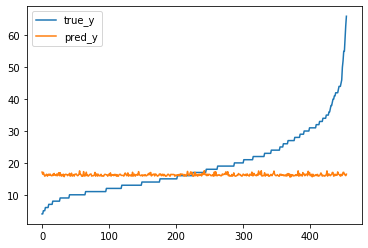

In [182]:
res = pd.DataFrame({'true_y': label_test_set, 'pred_y': y_pred.reshape(-1, )}).sort_values(by='true_y').reset_index(drop=True)

plt.plot(res.index, res['true_y'], label='true_y')
plt.plot(res.index, res['pred_y'], label='pred_y')
plt.legend()
plt.show()